In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

## Load data

In [3]:
rice_data = arff.loadarff(r"C:\Users\Zafee\Downloads\csci218\rice+cammeo+and+osmancik\Rice_Cammeo_Osmancik.arff")

In [4]:
df = pd.DataFrame(rice_data[0])
df

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'
...,...,...,...,...,...,...,...,...
3805,11441.0,415.858002,170.486771,85.756592,0.864280,11628.0,0.681012,b'Osmancik'
3806,11625.0,421.390015,167.714798,89.462570,0.845850,11904.0,0.694279,b'Osmancik'
3807,12437.0,442.498993,183.572922,86.801979,0.881144,12645.0,0.626739,b'Osmancik'
3808,9882.0,392.296997,161.193985,78.210480,0.874406,10097.0,0.659064,b'Osmancik'


In [5]:
classes = df["Class"].value_counts()
classes_df = pd.DataFrame(classes)
classes_df = classes.reset_index(level = 0)
classes_df

,Class,count
0,b'Osmancik',2180
1,b'Cammeo',1630


In [6]:
seed=42

## Spliting

In [8]:
X = df.drop(["Class"], axis=1)
y = df["Class"]


### train and test set

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify = y, random_state = 42)

## Standardization

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## find best parameters

In [14]:
pipe = Pipeline([("scaler", preprocessing.StandardScaler()),
                 ("Classifier", LogisticRegression(max_iter = 1000, random_state = seed))])
# Searching parameters
params = [{"Classifier__solver": ["liblinear"], 
           "Classifier__penalty": ["l1", "l2"],
           "Classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
# Creating grid
lr_clf_grid = GridSearchCV(estimator = pipe,
                           param_grid = params,
                           cv = StratifiedKFold(n_splits = 10, 
                                                shuffle = True,
                                                random_state = seed),
                           refit = True,
                           verbose = 2,
                           scoring = "accuracy")
# Fit the model
lr_model = lr_clf_grid.fit(X_train, y_train)

# Get best parameters
print("Best parameters for Logistic Regression model: ", lr_model.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END C

In [15]:
lr_best = pd.DataFrame.from_dict(lr_model.best_params_, orient = "index").rename(columns = {0: "Best"})
lr_best

,Best
Classifier__C,10
Classifier__penalty,l2
Classifier__solver,liblinear


## fit and train model

In [17]:
lr_clf = LogisticRegression(C = float(lr_best.iloc[0,0]),
                            penalty = lr_best.iloc[1,0],
                            solver = lr_best.iloc[2,0],
                            max_iter = 1000, 
                            random_state = seed)
# Fitting the model
lr_clf.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=1000, random_state=42, solver='liblinear')

In [18]:
lr_pred = lr_clf.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Model Accuracy:", lr_acc)
lr_acc_tr = lr_clf.score(X_train, y_train)
print("Logistic Regression Training Accuracy:", lr_acc_tr)

Logistic Regression Model Accuracy: 0.9225721784776902
Logistic Regression Training Accuracy: 0.9356955380577427


In [19]:
print("Logistic Regression Classification Report\n\n", classification_report(y_test, lr_pred))

Logistic Regression Classification Report

               precision    recall  f1-score   support

           0       0.92      0.89      0.91       652
           1       0.92      0.94      0.93       872

    accuracy                           0.92      1524
   macro avg       0.92      0.92      0.92      1524
weighted avg       0.92      0.92      0.92      1524



## Confusion Matrix

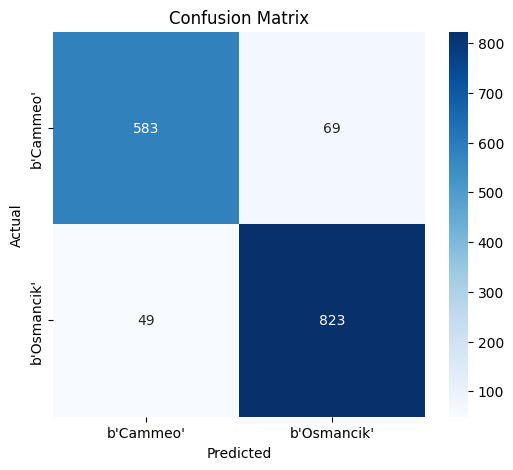

In [21]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()